**Optical Character Recognition:** which is also known as image-text recognition is the development of a neural network model for reading text from image data. This is done by combining convolutional neural networks,bi-directional long-short term memory (Bi-LSTM) networks & the correctionist temporal classification (C.T.C) loss function. These 3 main part would be explained<br>
1. Convolutional neural network (C.N.N): This is the neural network for image-processing,it is the 1st layer for the O.C.R model & it will be used to read the text off the images & send the read text to the next part.
2. Bi-directional long-short term memory (Bi-LSTM): this type of lstm network is different form the tradditional lstm in that it reads the data sequence from both past to future & future to past(tradditional lstm only reads from past to future) & then creates an output from both point of views,this makes it better at understanding the concept since it's observing the sequence from where it's coming & where it's going to at the same time. In the O.C.R model the bi-lstm will be the 2nd layer & it the prediction value of the cnn layer as it's own input,it would then process it & produce it's own predictions through a Dense layer which would then given to next part.
3. Correctionist temporal classification (C.T.C) loss function: This is a function created to calculate the loss for sequential predictions in which the sequential placement of a particular value isn't constant(i.e a value can span through more than one sequential/timestep postion) like in O.C.R where one letter/character can span through more than pixel(representation of a row) in an image. in our O.C.R the CTC function would calculate the loss between the prediction of the bi-lstm layer & the actual labels,this loss can then be used for backpropagation to update weights & biases
**Using the CTC function during training(Encoding)**
- it collects the model predictions(which would be a matrix,the rows would represent all characters used for text data ie the alpahbets in both upper & lower case forms,the numbers 0-9 & a blank character,the columns would represent the data timesteps),the actual labels(each label converted from string texts to numeric vectors),the length of the predictions(prediction matrix timestep length) & the length of each label.
- for labels that have double or multi-placed (ie characters that follow each other successively) eg words like book or fool with 2 successive "o"s,the ctc function puts the blank character(lets represent this as -) between each character ie book would be bo-ok,fool will be fo-ol.
- The function then takes the prediction matrices & works through all possible character combinations per timestep to arrive at  the labels,these combinations are collectively known as a path & the value for a path is calculated by multiplying the values of each character per timestep in that path but there can be more than one path to getting the same label & so the probability of a label being correct is calculated by adding the values of every path calculated by the function to get that label,the loss is then calculated by getting the negative logarithim of that probaility & hence with this the weights & biases of both the CNN & Bi-LSTM can be updated through back-propagation.<br>

**Using the CTC function during testing(Greedy Decoding method)**
- it creates the best path by selecting the character with the max probabilty at each timestep
- The created paths don't usually lead to the prediction of textually accurate labels,characters would usually be duplicated & for labels with double/multi-placed characters(eg fool,book) there would be blank characters to seperate identical ones,so to get the actual labels the function would merge all duplicate characters as one & remove the blanks seperating identical characters thus what's left would be the predicted labels.<br>

Greedy method is the simplest method for CTC prediction in OCR,the more complex method is beam search..

In [2]:
# import neccessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input,Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.callbacks import ModelCheckpoint

In [2]:
import pandas as pd,string,cv2

In [3]:
# main path of the image data
main_path = "C:/Users/LENOVO/Downloads/word_images"

In [4]:
# creating the image dataframe with the path to each image & the labels
data = pd.read_csv(f'{main_path}/annotation_train.txt',sep="\t")
data['labels'] = data['annotation_image_path'].apply(lambda x:x.split('_')[1].lower())
data['annotation_image_path'] = data['annotation_image_path'].apply(lambda x:f"{main_path}{x[1:].split(' ')[0]}")
data.head()

,annotation_image_path,labels
0,C:/Users/LENOVO/Downloads/word_images/2425/1/1...,lube
1,C:/Users/LENOVO/Downloads/word_images/2425/1/1...,spencerian
2,C:/Users/LENOVO/Downloads/word_images/2425/1/1...,accommodatingly
3,C:/Users/LENOVO/Downloads/word_images/2425/1/1...,carpenter
4,C:/Users/LENOVO/Downloads/word_images/2425/1/1...,regurgitating


In [45]:
# function for plotting the images
def view_images(dt):
    plt.figure(figsize=(20, 20))
    image = dt['annotation_image_path'].values
    label = dt['labels'].values
    fdt = zip(image,label)
    i = 0
    c = 0
    for img,lbl in fdt:
        ax = plt.subplot(dt.size,5 , c + 1)
        img = cv2.imread(img)
        plt.imshow(img.astype("uint8"))
        i = i+1
        c = c+1
    return ax

<AxesSubplot:>

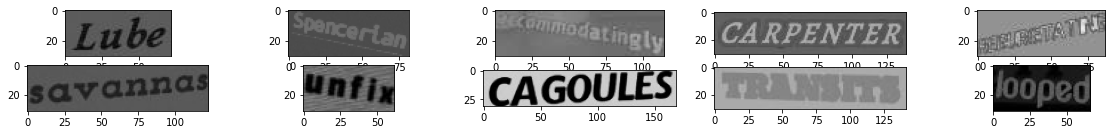

In [46]:
view_images(data[0:10])

In [ ]:
# getting all the characters used for text data from the "string" library
char_list = string.ascii_letters+string.digits

In [5]:
# function for encoding each output word into digits
def encode_to_labels(txt):
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return np.asarray(dig_lst)

In [7]:
# lists for training dataset
training_img = [] #train images
training_txt = [] # encoded train labels
train_orig_txt = [] # pre-encoded train labels
 
#lists for validation dataset
valid_img = [] #test images
valid_txt = [] # encoded test labels
valid_orig_txt = [] # pre-encoded test labels
 
max_label_len = 0 # maximum label length
img_height = 128 # height to set for every image
img_width = 32 # width to set for every image
# reading the images
for i in range(50000):
    img = cv2.cvtColor(cv2.imread(data.iloc[i][0]), cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_height, img_width))
    img = img/255
    txt = data.iloc[i][1]
    # compute maximum length of the text
    if len(txt) > max_label_len:
        max_label_len = len(txt)
    # split the data into validation and training dataset as 10% and 90% respectively
    if i%10 == 0:     
        valid_orig_txt.append(txt)   
        valid_img.append(img)
        valid_txt.append(encode_to_labels(txt)) # encoding the validation labels
    else:
        train_orig_txt.append(txt)   
        training_img.append(img)
        training_txt.append(encode_to_labels(txt)) # encoding the training labels

In [8]:
# padding the encoded labels so that they would have a uniform length
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [9]:
# creating the CTC class to calculate the training loss & be later added to the model
class CTCLayer(layers.Layer): # the CTC inherits the keras layers functional properties meaning that the CTC class can be added as a layer to the model 
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred): 
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64") # extracting the batch size
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64") # extracting the sequence length of the predictions as the input length
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64") # extracting the lenght of each label

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64") # turning the input length into an array
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64") # turning the label length into an array

        loss = self.loss_fn(y_true, y_pred, input_length, label_length) # calculating the loss function
        self.add_loss(loss) # adding the calculated loss as part of the layer
        # At test time, just return the computed predictions
        return y_pred

**Building & training the model:** the model would first be bulit bare by stacking the necessary layers on each other,then at the end we would create the model object & set the input & outputs. The first group of layers will be the 2 input layers the 1st one taking the image data to feed to the model proper,while the 2nd one would take the label data which would be later given to the CTC loss function alongside the model prediction,the next group of layers would be the CNN et al which would take the image data & output it's own prediction which would be a 3-d matrix,this will go into a Lambda layer which is a layer that allows model outputs to computed by custom functions & operations,within the Lambda layer we would create a lambda function which is supposed to take the 3-d matrix output of the CNN layers & squeeze it into a 2-d matrix for the next layers to use,the squeezing will be done by the "squeeze" method from "keras.backend" it's args would be the value to squeeze & then the dimension to squeeze at,the squeeze output will now be given to the Bi-LSTM layers which would process the data in bi-directional sequences & give an output to a final Dense layer which would give the final output of the model,note that the number of units this Dense layer would have would be the total number of characters used for textual data(a-z,A-Z,0-9) + 1(the 1 represents a character for blank) the activator function will be softmax,this way the Dense layer will output a probaility matrix with the characters as rows & columns of sequences this output will be the model prediction.The next thing to do is instantiating the CTC loss function as the final layer to the model,the function would take the labels & the output from the Dense layer to calculate the loss,after this we would instantiate the model with the "keras.models.Model" function within this function we would set the input kwarg as a list containing the image & label input layers & the ouput being the loss function layer,we then compile the model by setting the optimizer,view model summary & then train the model..

In [10]:
# building bare model
# input layers
inputs = Input(shape=(32,128,1)) # input with shape of height=32 and width=128 transposing the images
labels = Input(name='the_labels',shape=(None,), dtype='float32') # input for the labels


# convolution layers,along with max pooling & batchnormalisation layers
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7) # custom lambda layer to squeeze the CNN predictions from 3-d to 2-d matrices so they can be processed by the Bi-LSTM layers
 
# bidirectional LSTM layers with 
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
prediction = Dense(len(char_list)+1, activation = 'softmax')(blstm_2) # number of dense layer units being the length of all text characters + 1 representing blank space

In [12]:
# instantiating the loss function
loss_output = CTCLayer(name="ctc_loss")(labels, prediction)

In [13]:
# creating the model proper
model = keras.models.Model(inputs=[inputs, labels], outputs=loss_output)

In [14]:
model.compile(optimizer = 'adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 128, 64)  640         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 64, 128)  73856       ['max_pooling2d[0][0]']      

In [15]:
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [16]:
training_img = np.asarray(training_img)
training_txt = np.asarray(training_txt,dtype='object')

In [18]:
valid_img = np.asarray(valid_img)
valid_txt = np.asarray(valid_txt,dtype='object')

In [20]:
batch_size = 32
epochs = 10
model.fit(x=[training_img, train_padded_txt], batch_size=batch_size, epochs = epochs,callbacks=callbacks_list,
          validation_split=0.3)

Epoch 1/10
985/985 [==============================] - ETA: 0s - loss: 24.8081
Epoch 1: val_loss improved from inf to 24.15223, saving model to best_model.hdf5
985/985 [==============================] - 6955s 7s/step - loss: 24.8081 - val_loss: 24.1522
Epoch 2/10
985/985 [==============================] - ETA: 0s - loss: 20.9199
Epoch 2: val_loss improved from 24.15223 to 14.32465, saving model to best_model.hdf5
985/985 [==============================] - 6894s 7s/step - loss: 20.9199 - val_loss: 14.3246
Epoch 3/10
985/985 [==============================] - ETA: 0s - loss: 7.5145
Epoch 3: val_loss improved from 14.32465 to 5.55416, saving model to best_model.hdf5
985/985 [==============================] - 6784s 7s/step - loss: 7.5145 - val_loss: 5.5542
Epoch 4/10
985/985 [==============================] - ETA: 0s - loss: 4.5588
Epoch 4: val_loss improved from 5.55416 to 4.52352, saving model to best_model.hdf5
985/985 [==============================] - 6807s 7s/step - loss: 4.5588 - val

For predictions we would restructure the trainde model by making the image data layer as the only input layer & the dsense layer as the output layer,but since the output would be character sequence matrix we would to get the proper labels with the CTC decoder function,but this predictons would still be a list of integers with each numeric value representing a text character(not to forget the padding values),these lists would need to be decoded back to text characters & the pading values be removed..

In [22]:
# restructuring the trained model with the "keras.models.Model" class
prediction_model = keras.models.Model(
    model.get_layer(index=0).input, # here the trained model's ".get_layer" method is used to target the image data layer which is at index 0 & this layer is set as the input layer wih the ".input" property
    model.get_layer(index=18).output # here the trained model's ".get_layer" method is used to target the dense layer which is at index 18 & this layer is set as the output layer wih the ".output" property
)
prediction_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        2951

In [78]:
# function to convert the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT 
def words_from_labels(labels):
    preds = [] # list for hold the batch of predicted labels
    for words in labels.numpy(): # iterating throught the batch of predicted labels which is originally a tensorflow/eagertensor object but converted to a numpy array with the ".numpy" method
        words = list(words) # each word array is converted from a numpy array to a list
        flt = [0,0] # sensor list for removing the padded values
        txt=[] # list for holding each word
        for ele in words: # iterating through each words to get characters
            if ele == len(char_list): # this represents the blank character given by the CTC function
                txt.append("")
            else:
                if ele == -1: # "-1" represents the padded value predictions
                    # the aim here is to count how many of the integer values in the prediction lists are successively equal to "-1" ie a padded value & when the count is greater than 4
                    # the presence of the padded values would be affirmed & they will be removed the predictions 
                    flt[0] += 1
                    flt.append(words.index(ele))
                    if flt[0] == 4:
                        txt = txt[:flt[-1]]
                    else:
                        pass
                else:
                    txt.append(char_list[ele]) # getting the index of each predicted integer in the list of textual characters to get their corresponding letter
        txt = "".join(txt) # turning the word lists into strings
        preds.append(txt) # appending each decoded word into the batch list

    return preds

In [33]:
# creating a utility function to decode the output of the network
def decode_batch_predictions(pred):
    # to decode the model predictions we would use the "keras.backend.ctc_decode" function which would take the model predictions
    # & the input length of the predictions as values,it's "greedy" kwarg will be set to True meaning we should use the greedy method for
    # decoding.The final results of the decoding would be an eagertensor dataframe & to get the bacth of predicted labels we would slice
    # the dataframe columns by the maximum length of the labels,with the rows being constant
    input_len = np.ones(pred.shape[0]) * pred.shape[1] # generating the input/sequence length as an array
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][: , :max_label_len]
    return words_from_labels(results)

In [80]:
# doing the predictions
preds = prediction_model.predict(valid_img)
pred_texts = decode_batch_predictions(preds)
pred_texts

['lube',
 'gowmen',
 'vaxes',
 'shslol',
 'biol',
 'populace',
 'graffito',
 'libretto',
 'floss',
 'pests',
 'overcautious',
 'cleanse',
 'lsuwny',
 'promote',
 'woodblocks',
 'searchers',
 'airlock',
 'sioux',
 'monumentat',
 'remarking',
 'delusions',
 'srtbakiest',
 'aistter',
 'owned',
 'prossshosd',
 'hepburn',
 'sassy',
 'mbxwel',
 'unsettled',
 'compacter',
 'knotted',
 'spanrss',
 'ambulations',
 'reclaiming',
 'jerahri',
 'unexploited',
 'skipped',
 'jeak',
 'caemate',
 'nemsdbiler',
 'rasher',
 'babblers',
 'fireprooes',
 'samisittes',
 'chastise',
 'kneeing',
 'dethaction',
 'reflection',
 'khazat',
 'sobs',
 'blackthorns',
 'fitfully',
 'sustarability',
 'deselects',
 'coupling',
 'oilosssiss',
 'e',
 'greener',
 'cirglies',
 'routers',
 'consideration',
 'dedications',
 'seamed',
 'unsamilaty',
 'shrinkng',
 'fdos',
 'eldest',
 'sblahe',
 'avant',
 'implementer',
 'beotangle',
 'sorisbad',
 'doodlebugs',
 'entfrety',
 'noncontogious',
 'unorstss',
 'mantrs',
 'woodshed',
